In [1]:
import numpy as np
from numpy import inf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure as fig
from sklearn.linear_model import LinearRegression
from scipy import optimize

# Ignore numpy divide by zero errors in numpy
np.seterr(divide='ignore')

# Ignore warning about chained assignments in pandas
pd.options.mode.chained_assignment = None  # default='warn'

# FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. 
# The converter was registered by pandas on import. Future versions of pandas will require you to 
# explicitly register matplotlib converters.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

I found this dataset on https://stockx.com/news/the-2019-data-contest. The dataset contains resell transaction records from StockX. It is important to note that these are not all the sales during the period but a random sample (conducted by StockX). It is limited to only the Nike/Off-White collaboration and Adidas Yeezy line. The few cells below provide a brief summary of the data.

In [2]:
data = pd.read_excel('StockX-Data-Contest-2019-3.xlsx')

In [3]:
data.describe()

,Sale Price,Retail Price,Shoe Size
count,99956.000000,99956.00000,99956.000000
mean,446.634754,208.61359,9.344181
std,255.982918,25.20001,2.329588
min,186.000000,130.00000,3.500000
25%,275.000000,220.00000,8.000000
50%,370.000000,220.00000,9.500000
75%,540.000000,220.00000,11.000000
max,4050.000000,250.00000,17.000000


In [4]:
nike = data[data['Brand'] == 'Off-White']
brand = nike['Brand']
print(f'There are {brand.count()} Nike/Off-White records.')
nike.head()

There are 27794 Nike/Off-White records.


,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
128,2017-09-07,Off-White,Nike-Air-Max-90-Off-White,1600.0,160,2017-09-09,8.0,California
129,2017-09-07,Off-White,Nike-Air-Max-90-Off-White,1090.0,160,2017-09-09,11.5,New York
130,2017-09-07,Off-White,Nike-Air-Presto-Off-White,1344.0,160,2017-09-09,10.0,New York
131,2017-09-07,Off-White,Nike-Air-Presto-Off-White,1325.0,160,2017-09-09,10.0,Massachusetts
132,2017-09-07,Off-White,Nike-Air-VaporMax-Off-White,1800.0,250,2017-09-09,12.0,Kentucky


Let's first take a look at the amount of transactions over time,

In [5]:
def display_figure(counts, specific_dates=None):
    plt.figure(figsize=(18, 6))
    plt.plot(counts)
    plt.xticks(rotation=90)
    
    if specific_dates:
        for date in specific_dates:
            plt.axvline(x=date, color='gray')
    
    plt.show()

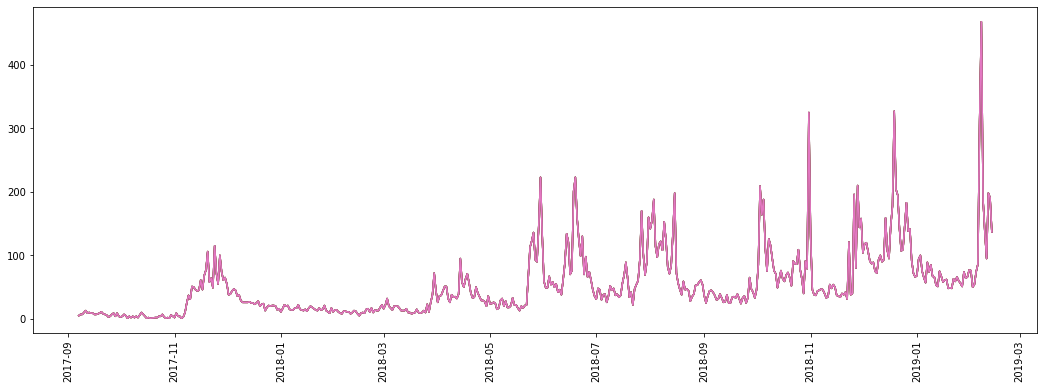

In [6]:
sell_count = nike.groupby('Order Date').count()
display_figure(sell_count)

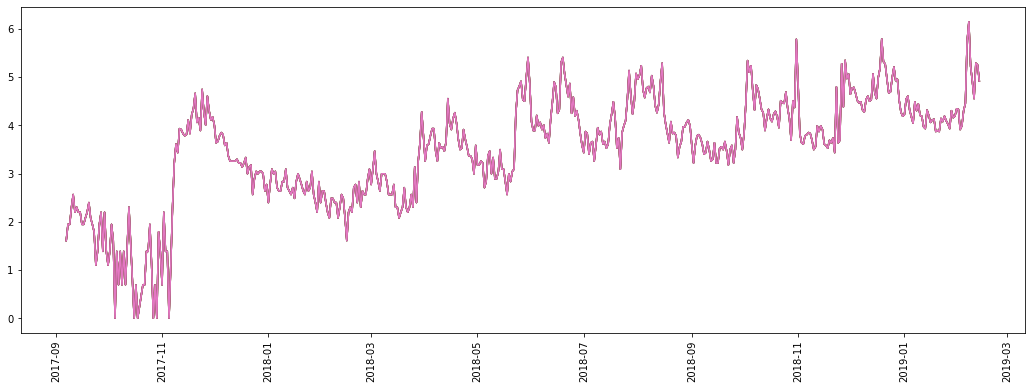

In [7]:
# since the peaks dwarf the rest of the values, I applied a log on the series. 
log_sell_count = np.log(sell_count)
display_figure(log_sell_count)

Interesting! There are a handful of spikes, I'm guessing they match with the release dates of "The Ten" models. Let's see if that is true. First, let's find all the unique release dates. 

In [8]:
release_dates = nike['Release Date']
release_dates = release_dates.drop_duplicates()
release_dates = list(release_dates)
release_dates

[Timestamp('2017-09-09 00:00:00'),
 Timestamp('2017-11-01 00:00:00'),
 Timestamp('2017-11-04 00:00:00'),
 Timestamp('2018-04-14 00:00:00'),
 Timestamp('2018-03-03 00:00:00'),
 Timestamp('2018-03-30 00:00:00'),
 Timestamp('2018-06-23 00:00:00'),
 Timestamp('2018-07-27 00:00:00'),
 Timestamp('2018-08-03 00:00:00'),
 Timestamp('2018-06-14 00:00:00'),
 Timestamp('2018-08-25 00:00:00'),
 Timestamp('2018-10-03 00:00:00'),
 Timestamp('2018-10-18 00:00:00'),
 Timestamp('2018-10-13 00:00:00'),
 Timestamp('2018-11-28 00:00:00'),
 Timestamp('2018-12-19 00:00:00'),
 Timestamp('2019-02-07 00:00:00')]

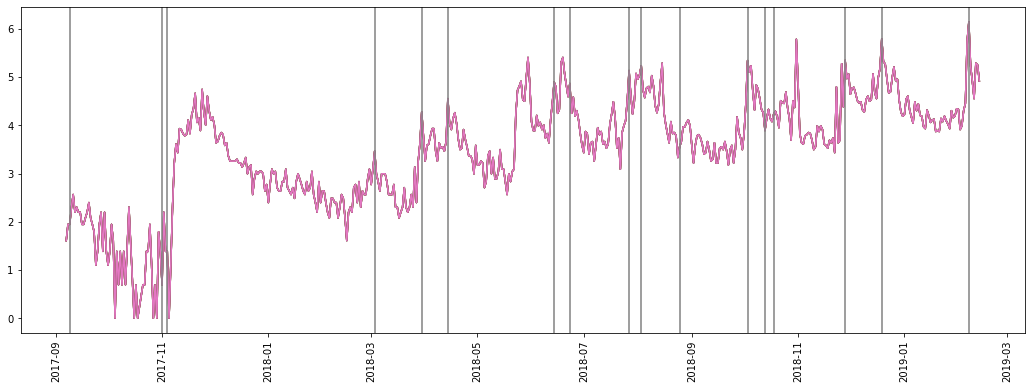

In [9]:
display_figure(log_sell_count, release_dates)

It seems like a few of the spikes line up with release dates, but other spikes don't. I wonder why? Let'see which models caused which spikes.

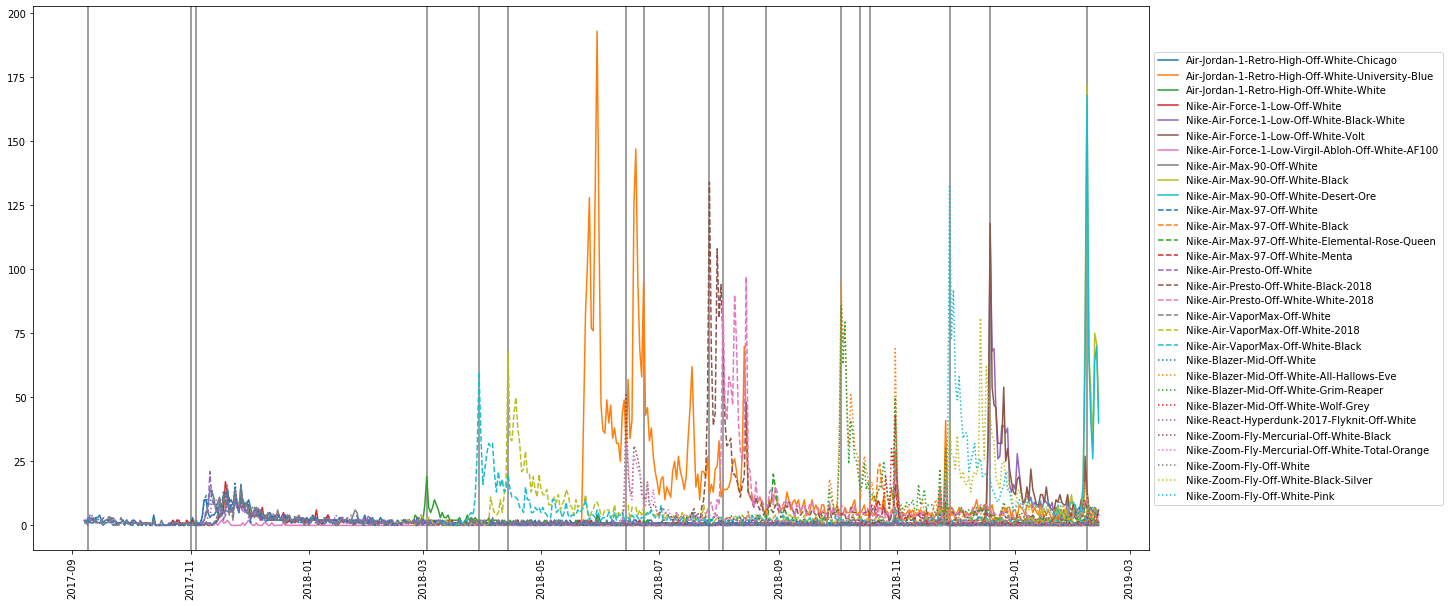

In [10]:
END_DATE = '2019-02-13'

# group each model by the count sold each day
sell_by_model_count = nike.groupby(['Sneaker Name','Order Date']).count()['Brand'].reset_index('Order Date')

# initialize the lists that have models
models = list(sell_by_model_count.index.drop_duplicates())

# generate new figure
plt.figure(figsize=(20, 10))
for date in release_dates:
    plt.axvline(x=date, c='gray')

# plt.plot(sell_count)

for model in models:
    
    # line style
    model_index = models.index(model)
    if model_index < 10:
        ls = '-'
    elif model_index < 20:
        ls = '--'
    else:
        ls = ':'
    start_date = min(sell_by_model_count.loc[model]['Order Date'])
    
    # https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
    curr_model_count = sell_by_model_count.loc[model].reset_index().drop('Sneaker Name', axis=1).set_index('Order Date')
    date_series = pd.date_range(start=start_date, end=END_DATE)
    
    curr_model_count = curr_model_count.reindex(date_series, fill_value=0)
    
    plt.plot(curr_model_count, label=model, linestyle=ls)
    plt.xticks(rotation=90)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

*I went back to the non-log graph because even though this looks very congested between 0 and 25 the log-transformed graph looked worse.*

It turns out that StockX allows resells before the official drop. 

Not the prettiest graph in the world, but it does provide some insight as to when some of the hype for these releases started sales __before they were even released__! It could be better since the colors repeat, but for now , I have changed the linestyle so you can hopefully make out which lines are associated with each model. For example, the prominent orange line and spike in the middle is a shoe that was released at the line right before 2018-07!

Almost universally, we can see a steep decline in sales after the release date. This is likely due to the fact that the people who couldn't get it directly from Nike resorted to buying it second hand. It is also due to the fact that the hype around the shoes declines as people get the shoes and wear them. I've defined the hype "dying" as when it's average comes back to normal sale amounts. What I did was I created a model to fit the number of resells after the largest peak. Then, I analyzed after how long it took for the hype to die, based on my model.

In [11]:
sneakers = sell_by_model_count.reset_index().groupby('Sneaker Name')

-----

With a peak of 16 resells on Nov 27 2017, the Air-Jordan-1-Retro-High-Off-White-Chicago's hype fell below the average sales (based on my model) after 92 days.


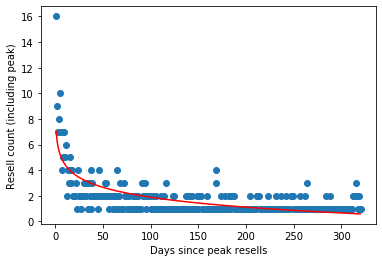

-----

With a peak of 193 resells on May 30 2018, the Air-Jordan-1-Retro-High-Off-White-University-Blue's hype fell below the average sales (based on my model) after 87 days.


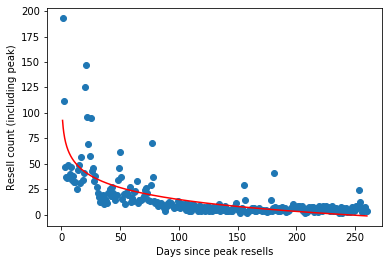

-----

With a peak of 19 resells on Mar 03 2018, the Air-Jordan-1-Retro-High-Off-White-White's hype fell below the average sales (based on my model) after 62 days.


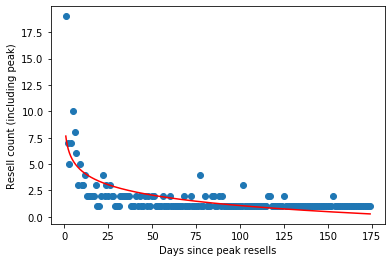

-----

With a peak of 17 resells on Nov 19 2017, the Nike-Air-Force-1-Low-Off-White's hype fell below the average sales (based on my model) after 87 days.


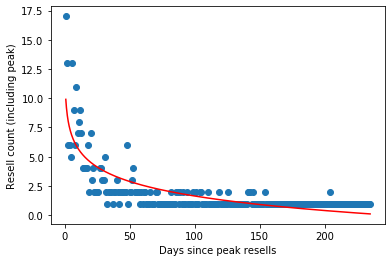

-----

With a peak of 113 resells on Dec 19 2018, the Nike-Air-Force-1-Low-Off-White-Black-White's hype fell below the average sales (based on my model) after 23 days.


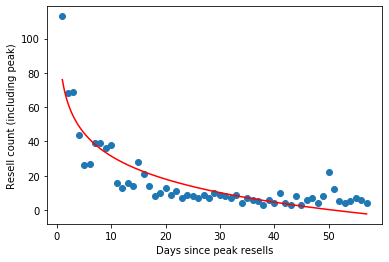

-----

With a peak of 118 resells on Dec 19 2018, the Nike-Air-Force-1-Low-Off-White-Volt's hype fell below the average sales (based on my model) after 23 days.


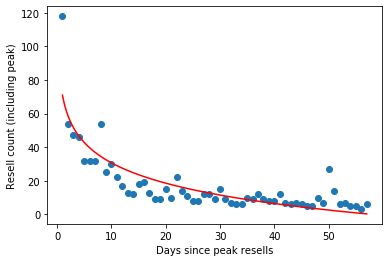

-----

With a peak of 2 resells on Nov 17 2017, the Nike-Air-Force-1-Low-Virgil-Abloh-Off-White-AF100's hype fell below the average sales (based on my model) after 10 days.


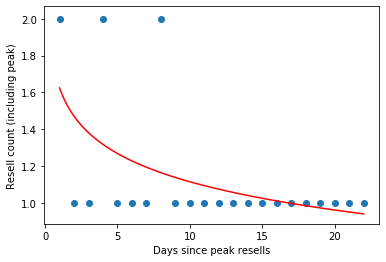

-----

With a peak of 15 resells on Nov 24 2017, the Nike-Air-Max-90-Off-White's hype fell below the average sales (based on my model) after 79 days.


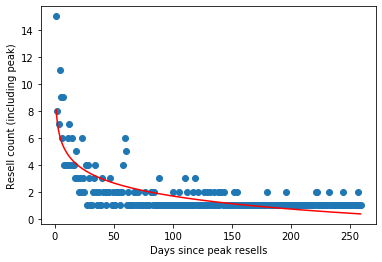

-----

With a peak of 172 resells on Feb 07 2019, the Nike-Air-Max-90-Off-White-Black's hype fell below the average sales (based on my model) after 10 days.


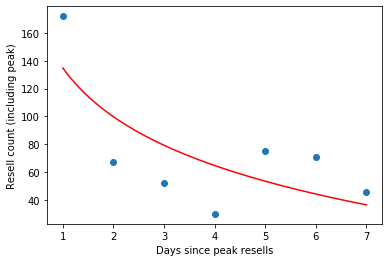

-----

With a peak of 168 resells on Feb 07 2019, the Nike-Air-Max-90-Off-White-Desert-Ore's hype fell below the average sales (based on my model) after 8 days.


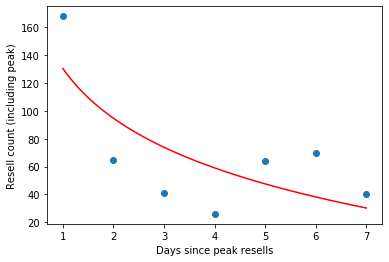

-----

With a peak of 14 resells on Nov 20 2017, the Nike-Air-Max-97-Off-White's hype fell below the average sales (based on my model) after 96 days.


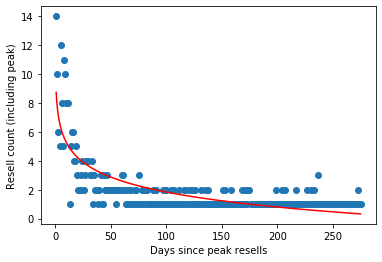

-----

With a peak of 24 resells on Oct 23 2018, the Nike-Air-Max-97-Off-White-Black's hype fell below the average sales (based on my model) after 26 days.


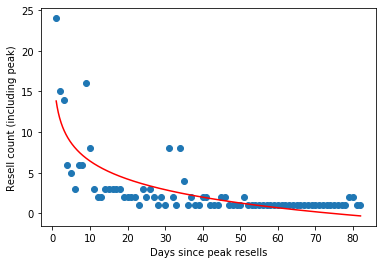

-----

With a peak of 20 resells on Aug 29 2018, the Nike-Air-Max-97-Off-White-Elemental-Rose-Queen's hype fell below the average sales (based on my model) after 30 days.


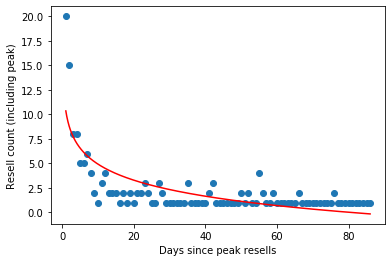

-----

With a peak of 16 resells on Oct 31 2018, the Nike-Air-Max-97-Off-White-Menta's hype fell below the average sales (based on my model) after 24 days.


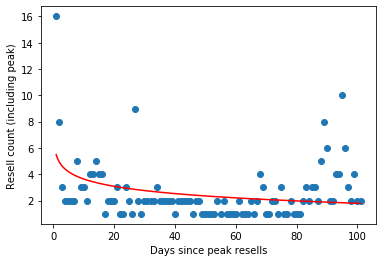

-----

With a peak of 21 resells on Nov 11 2017, the Nike-Air-Presto-Off-White's hype fell below the average sales (based on my model) after 106 days.


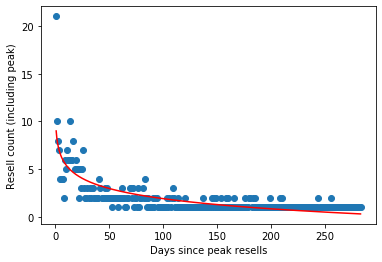

-----

With a peak of 134 resells on Jul 27 2018, the Nike-Air-Presto-Off-White-Black-2018's hype fell below the average sales (based on my model) after 77 days.


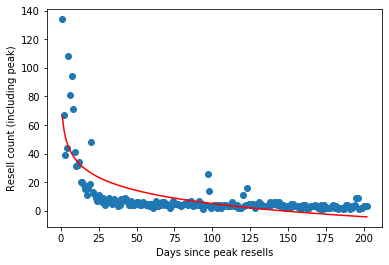

-----

With a peak of 97 resells on Aug 15 2018, the Nike-Air-Presto-Off-White-White-2018's hype fell below the average sales (based on my model) after 44 days.


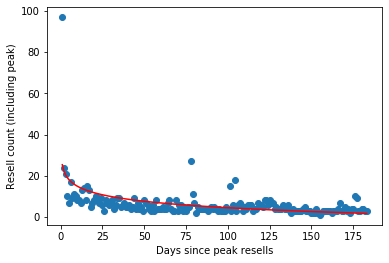

-----

With a peak of 15 resells on Nov 27 2017, the Nike-Air-VaporMax-Off-White's hype fell below the average sales (based on my model) after 71 days.


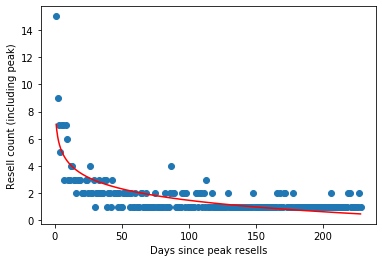

-----

With a peak of 68 resells on Apr 14 2018, the Nike-Air-VaporMax-Off-White-2018's hype fell below the average sales (based on my model) after 117 days.


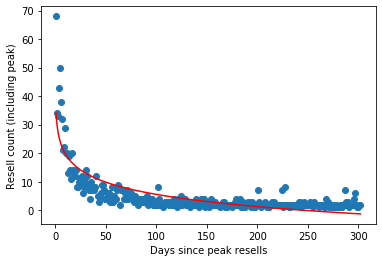

-----

With a peak of 60 resells on Mar 30 2018, the Nike-Air-VaporMax-Off-White-Black's hype fell below the average sales (based on my model) after 116 days.


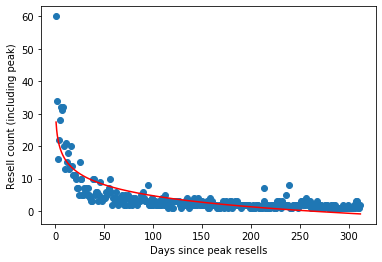

-----

With a peak of 17 resells on Nov 24 2017, the Nike-Blazer-Mid-Off-White's hype fell below the average sales (based on my model) after 58 days.


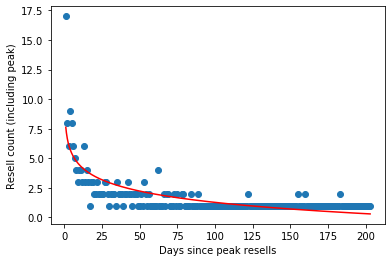

-----

With a peak of 95 resells on Oct 03 2018, the Nike-Blazer-Mid-Off-White-All-Hallows-Eve's hype fell below the average sales (based on my model) after 51 days.


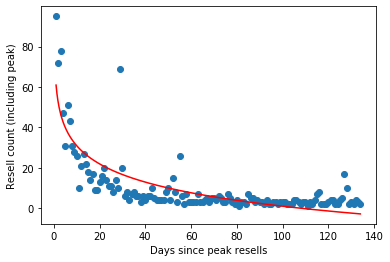

-----

With a peak of 86 resells on Oct 03 2018, the Nike-Blazer-Mid-Off-White-Grim-Reaper's hype fell below the average sales (based on my model) after 52 days.


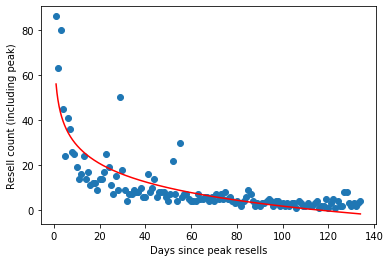

-----

With a peak of 43 resells on Oct 31 2018, the Nike-Blazer-Mid-Off-White-Wolf-Grey's hype fell below the average sales (based on my model) after 21 days.


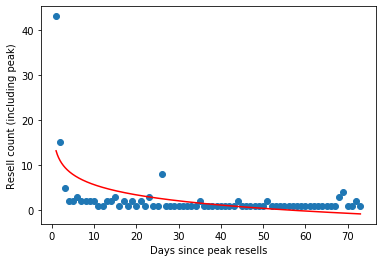

-----

With a peak of 12 resells on Nov 20 2017, the Nike-React-Hyperdunk-2017-Flyknit-Off-White's hype fell below the average sales (based on my model) after 79 days.


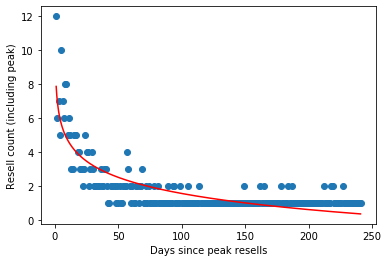

-----

With a peak of 51 resells on Jun 14 2018, the Nike-Zoom-Fly-Mercurial-Off-White-Black's hype fell below the average sales (based on my model) after 75 days.


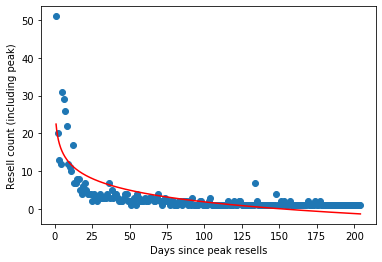

-----

With a peak of 32 resells on Jun 14 2018, the Nike-Zoom-Fly-Mercurial-Off-White-Total-Orange's hype fell below the average sales (based on my model) after 79 days.


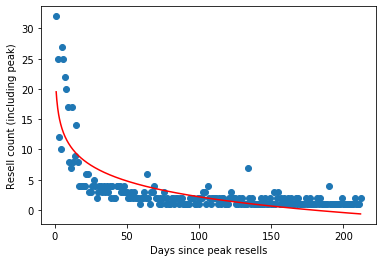

-----

With a peak of 16 resells on Nov 20 2017, the Nike-Zoom-Fly-Off-White's hype fell below the average sales (based on my model) after 77 days.


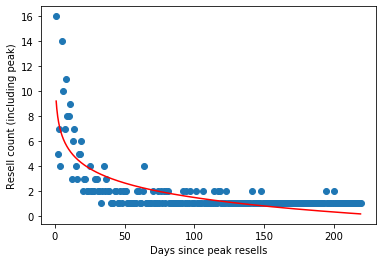

-----

With a peak of 81 resells on Dec 14 2018, the Nike-Zoom-Fly-Off-White-Black-Silver's hype fell below the average sales (based on my model) after 21 days.


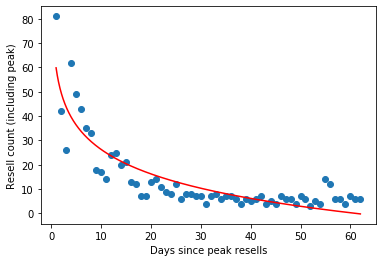

-----

With a peak of 133 resells on Nov 28 2018, the Nike-Zoom-Fly-Off-White-Pink's hype fell below the average sales (based on my model) after 30 days.


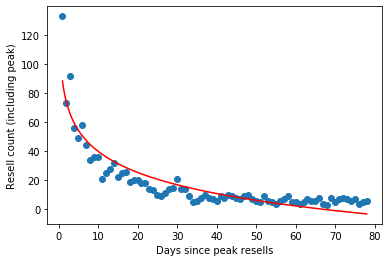

In [12]:
for sneaker in sneakers:
    df = sneaker[1]
    
    # find the peak, the date of the peak, and the average traded value
    peak = sneaker[1]['Brand'].max()
    peak_date = list(df[df['Brand']==peak]['Order Date'])[0]
    average = sneaker[1]['Brand'].mean()
        
    X = range(1, len(df[df['Order Date'] >= peak_date]) + 1)
    Y = df[df['Order Date'] >= peak_date]['Brand']

    # create the polynomial fit based on log of X
    fit_array = np.polyfit(np.log(X), Y, 1)
    x = np.linspace(1, len(X), 1000)
    
    # print the formula (if wanted)
    # print(f'y = {"{0:.2f}".format(fit_array[0])}*log(x)+{"{0:.2f}".format(fit_array[1])}')
    
    day_intercept = np.e ** ((average - fit_array[1]) / fit_array[0])
    print(f'-----\n\nWith a peak of {peak} resells on {peak_date.strftime("%b %d %Y")}, the {sneaker[0]}\'s hype fell below the average sales (based on my model) after {int(day_intercept)} days.')

    plt.scatter(X, Y)
    plt.ylabel('Resell count (including peak)')
    plt.xlabel('Days since peak resells')
    plt.plot(x, fit_array[0] * np.log(x) + fit_array[1], color='red')
    plt.show()


It is clear that the shoes that had the later releases (not as much data) have a quicker hype "death" because the average of their resells are higher if there are only 10 days to account for while other models have over 300. That is one thing I want to improve in the next version or figure out a way to take that into account. With that caveat in mind, the Nike Air VaporMax had the longest hype run of 117 days before it reached the average resell amount!

Another way of measuring hype would be the resale price. Often these limited releases cause sneakerheads to want them even more, which raises the prices. The below are the prices that these shoes resaled at. Compare those to the Retail Price. (Hint: Every single Sale Price is higher than the Retailed Price.

In [13]:
price_by_model = nike[['Sneaker Name', 'Sale Price', 'Retail Price']]
price_by_model['Count'] = 1

grouped_avg_price_by_model = price_by_model.groupby('Sneaker Name').agg({'Sale Price':'mean', 'Retail Price':'max', 'Count':'count'}).sort_values('Sale Price', ascending=False)
grouped_avg_price_by_model['Price Diff'] = grouped_avg_price_by_model['Sale Price'] - grouped_avg_price_by_model['Retail Price']
grouped_avg_price_by_model['% of Retail Price'] = grouped_avg_price_by_model['Price Diff'] / grouped_avg_price_by_model['Retail Price']
grouped_avg_price_by_model

,Sale Price,Retail Price,Count,Price Diff,% of Retail Price
Sneaker Name,,,,,
Air-Jordan-1-Retro-High-Off-White-White,1826.068894,190,313,1636.068894,8.610889
Air-Jordan-1-Retro-High-Off-White-Chicago,1769.800000,190,755,1579.800000,8.314737
Nike-Air-Presto-Off-White,1236.055369,160,596,1076.055369,6.725346
Nike-Air-Force-1-Low-Virgil-Abloh-Off-White-AF100,975.516129,150,31,825.516129,5.503441
Nike-Air-Max-97-Off-White-Elemental-Rose-Queen,893.782407,190,216,703.782407,3.704118
Nike-Air-VaporMax-Off-White,856.676190,250,525,606.676190,2.426705
Air-Jordan-1-Retro-High-Off-White-University-Blue,850.853503,190,4635,660.853503,3.478176
Nike-Blazer-Mid-Off-White-Wolf-Grey,784.822917,130,288,654.822917,5.037099
Nike-Air-Max-97-Off-White-Menta,752.672901,190,343,562.672901,2.961436


This shows that every single release generated some hype. Since they were all limited releases, all but one generated an average price difference of $100 *more* than the MSRP price. 26 of the 30 models had a price difference to retail price of over 100%! This means someone who bought Air-Jordan-1-Retro-High-Off-White-White at the resell price on StockX could have bought 8 at retail price if it were available to them (and still had some change left over). Nike is obviously generating a lot of hype with these collaborations.

Lastly, even though Nike x Off-White had only 27,794 out of the nearly 100,000 shoes in the data set, it still generated StockX more than half of the revenue.

In [14]:
data['Count'] = 1
stockx = data.groupby(['Brand', 'Sneaker Name']).agg({'Sale Price': 'mean', 'Retail Price': 'mean', 'Count':'count'})
stockx['Price Diff'] = stockx['Sale Price'] - stockx['Retail Price']
stockx['Revenue'] = stockx['Count'] * stockx['Price Diff'] * 0.0875
sums = stockx.groupby('Brand').sum().reset_index()
sums

,Brand,Sale Price,Retail Price,Count,Price Diff,Revenue
0,Yeezy,13056.862779,4300,72162,8756.862779,8.849868e+05
1,Off-White,21374.224025,5330,27794,16044.224025,1.196782e+06


In [15]:
total_shoes_sold = sum(sums['Count'])
nike_shoes_sold = sums[sums['Brand'] == 'Off-White']['Count'][1]
yeezy_shoes_sold = sums[sums['Brand'] == ' Yeezy']['Count'][0]

total_revenue = sum(sums['Revenue'])
nike_revenue = sums[sums['Brand'] == 'Off-White']['Revenue'][1]
yeezy_revenue = sums[sums['Brand'] == ' Yeezy']['Revenue'][0]

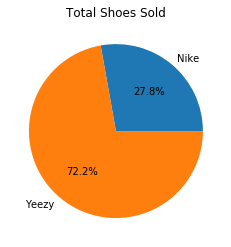

Percentage of StockX's shoes sold from Nike x Off-White: 27,794 and from Yeezy: 72,162


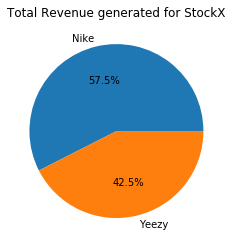

Dollars generated for StockX revenue from Nike x Off-White: $1,196,782.06 and from Yeezy: $884,986.75


In [16]:
plt.pie([nike_shoes_sold, yeezy_shoes_sold], labels=['Nike', 'Yeezy'], autopct='%1.1f%%')
plt.title('Total Shoes Sold')
plt.show()

print(f'Percentage of StockX\'s shoes sold from Nike x Off-White: {"{:,}".format(nike_shoes_sold)} and from Yeezy: {"{:,}".format(yeezy_shoes_sold)}')


plt.pie([nike_revenue, yeezy_revenue], labels=['Nike', 'Yeezy'], autopct='%1.1f%%')
plt.title('Total Revenue generated for StockX')
plt.show()

print(f'Dollars generated for StockX revenue from Nike x Off-White: ${"{:,.2f}".format(nike_revenue)} and from Yeezy: ${"{:,.2f}".format(yeezy_revenue)}')

My suggestion, as a conclusion to this analysis, is Nike should continue the hype train. If I had more **data** and time, I would do the following analysis:

- Look for features or attributes that could be correlated to generating more hype. 
- Compare the Off-White collaboration with the others that Nike has (Fear of God, Parra, Travis Scott, etc). 
- Do more analysis to create models that are time-proof so that even if there is limited data, we can still accurately predict how long the hype for a shoe will last.
- Lastly, and most importantly, how can (or how well does) this hype translate to Nike's bottom line? With just these shoes in the dataset, Nike's revenues were nearly \\$5 million, but StockX took nearly \\$1.2 million home from their reselling market.

Thanks for taking the time to read this! I would appreciate any feedback you have.